# Time Series Analysis of NYC Yellow Taxi Trips

In [1]:
%pip install kagglehub
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install statsmodels
%pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/cf/1c/83b87c760144281f0dc4df43578587b59fe3c38f9d660b575adb9480a11a/pmdarima-2.0.4-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/35/00/78ffea3a0ab176267a25ff049518b2582db7ac265bbf27944243d1a81ce2/Cython-3.0.11-cp312-cp312-win_amd64.whl.metadata
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
    --------------------------------------- 10.2/625.1 kB ? eta -:--:--
   ------- -------------------------------- 112.6/625.1 kB 1.3 MB/s eta 0:00:01
   --------------------- ------------------ 337.9/625.1 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --------- --------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import kagglehub
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima  # Per ottimizzazione automatica dei parametri

## Dataset loading

In [3]:
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")
file_path1 = os.path.join(path, "yellow_tripdata_2015-01.csv")
file_path2 = os.path.join(path, "yellow_tripdata_2016-01.csv")
file_path3 = os.path.join(path, "yellow_tripdata_2016-02.csv")
file_path4 = os.path.join(path, "yellow_tripdata_2016-03.csv")

file_paths = [
    #file_path1,
    file_path2,
    file_path3,
    file_path4]


In [4]:
# Columns of interest
columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'total_amount']

# Load the dataset into a pandas dataframe
dfs = [pd.read_csv(f, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) for f in file_paths]
df = pd.concat(dfs, ignore_index=True)

## Data cleaning

In [5]:
df.dropna(subset=columns, inplace=True)
df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0) & (df['total_amount'] > 0)]

## Time variables creation

In [6]:
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 240)]

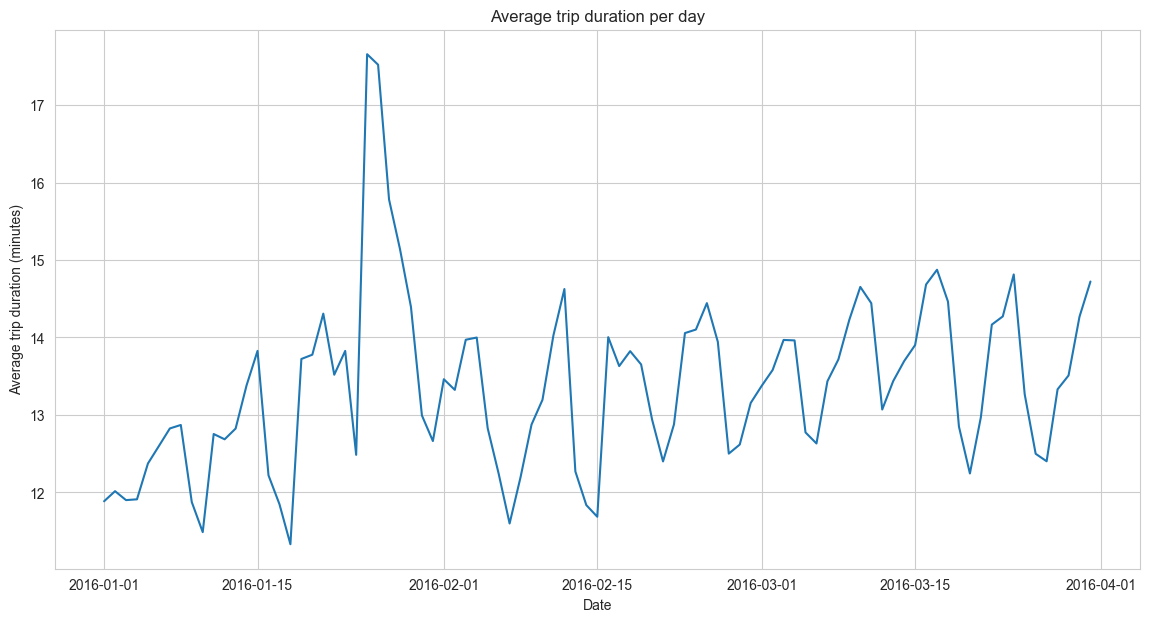

In [7]:
# Calculate the average duration of trips for each day
daily_avg_duration = df.groupby('pickup_date')['trip_duration'].mean()

# Visualize the trend of the average trip duration
plt.figure(figsize=(14, 7))
daily_avg_duration.plot()
plt.title('Average trip duration per day')
plt.xlabel('Date')
plt.ylabel('Average trip duration (minutes)')
plt.show()

## Stationarity analysis

In [8]:
daily_trips = df.groupby('pickup_date').size()

ts_daily_trips = daily_trips.copy()
ts_daily_trips.index = pd.to_datetime(ts_daily_trips.index)
ts_daily_trips = ts_daily_trips.asfreq('D', fill_value=0)

In [9]:
ts_daily_trips['2016-01-23'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 5].mean()
ts_daily_trips['2016-01-24'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 6].mean()
ts_daily_trips['2016-01-25'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 0].mean()
ts_daily_trips['2016-01-26'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 1].mean()

C:\Users\nickb\AppData\Local\Temp\ipykernel_24688\2654392441.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '391149.6153846154' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ts_daily_trips['2016-01-23'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 5].mean()


In [10]:
# Train and test
train_size = int(len(ts_daily_trips) * 0.8)
train_ts = ts_daily_trips[:train_size]
test_ts = ts_daily_trips[train_size:]

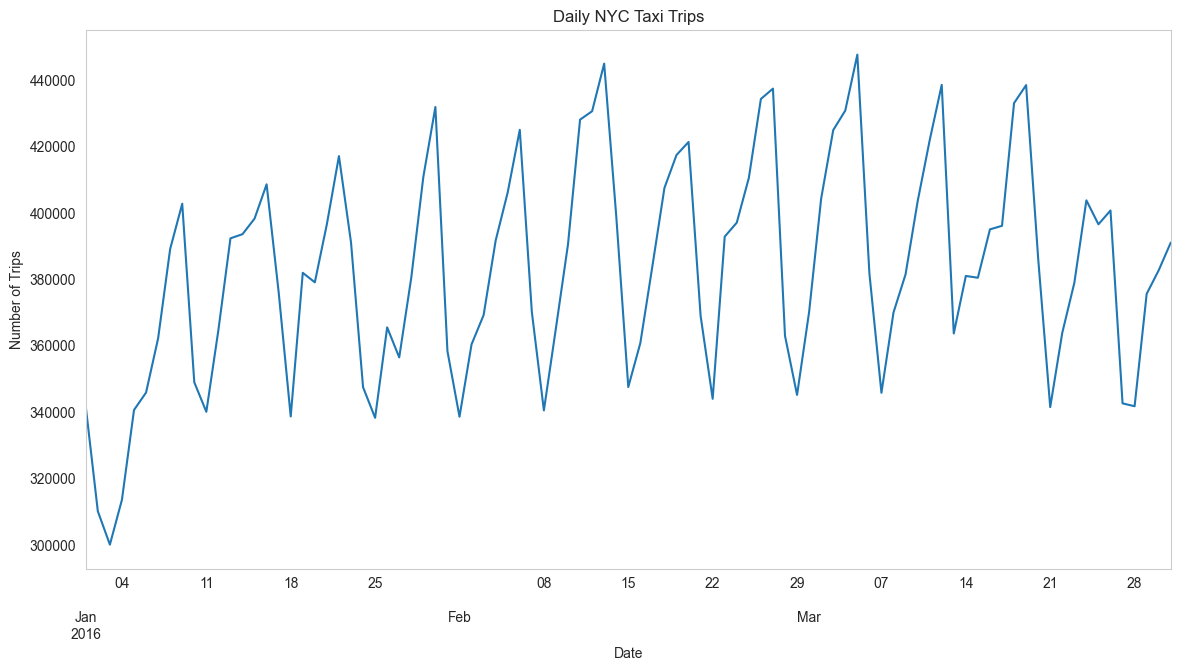

In [11]:
plt.figure(figsize=(14, 7))
ts_daily_trips.plot()
plt.title('Daily NYC Taxi Trips')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid()
plt.show()

In [12]:
def test_stationarity_with_interpretation(timeseries):
    result = adfuller(timeseries)
    print('=== Augmented Dickey-Fuller Test ===')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interpretazione del risultato
    if result[1] <= 0.05:
        print("\n✅ La serie è stazionaria")
    else:
        print("\n❌ La serie NON è stazionaria")

# Test sulla serie originale
print("\n[TEST SULLA SERIE ORIGINALE]")
test_stationarity_with_interpretation(train_ts)


[TEST SULLA SERIE ORIGINALE]
=== Augmented Dickey-Fuller Test ===
ADF Statistic: -3.4416
p-value: 0.009618529010986771
Critical Values:
   1%: -3.5369
   5%: -2.9079
   10%: -2.5915

✅ La serie è stazionaria


In [13]:
# Differenziazione stagionale per catturare la periodicità settimanale
ts_daily_trips_diff = ts_daily_trips.diff(7).dropna()
print("\n[TEST SULLA SERIE DIFFERENZIATA]")
test_stationarity_with_interpretation(ts_daily_trips_diff)


[TEST SULLA SERIE DIFFERENZIATA]
=== Augmented Dickey-Fuller Test ===
ADF Statistic: -3.2429
p-value: 0.01763274471597636
Critical Values:
   1%: -3.5195
   5%: -2.9004
   10%: -2.5875

✅ La serie è stazionaria


The $p$-value is less than $0.05$, which means that we can reject the null hypothesis that the time series is non-stationary. The time series is stationary.

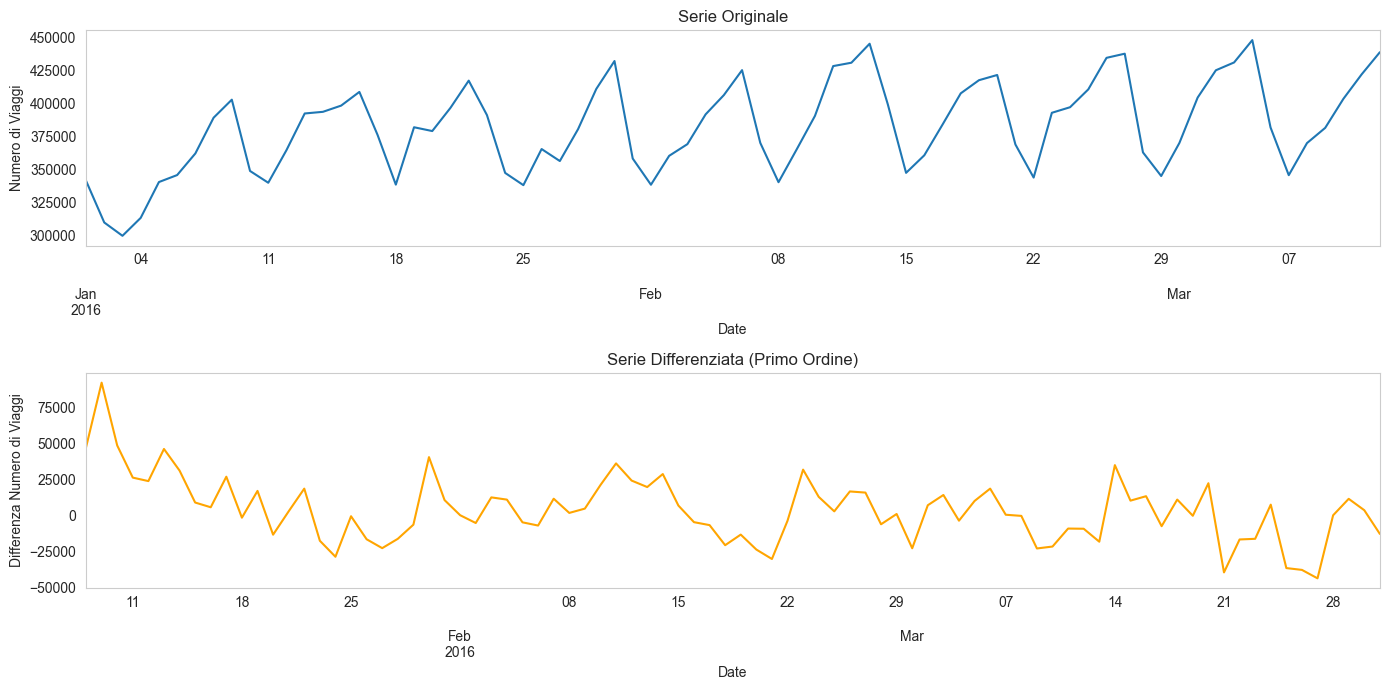

In [14]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
train_ts.plot(ax=plt.gca())
plt.title('Serie Originale')
plt.xlabel('Date')
plt.ylabel('Numero di Viaggi')
plt.grid()

plt.subplot(2, 1, 2)
ts_daily_trips_diff.plot(ax=plt.gca(), color='orange')
plt.title('Serie Differenziata (Primo Ordine)')
plt.xlabel('Date')
plt.ylabel('Differenza Numero di Viaggi')
plt.grid()
plt.tight_layout()
plt.show()

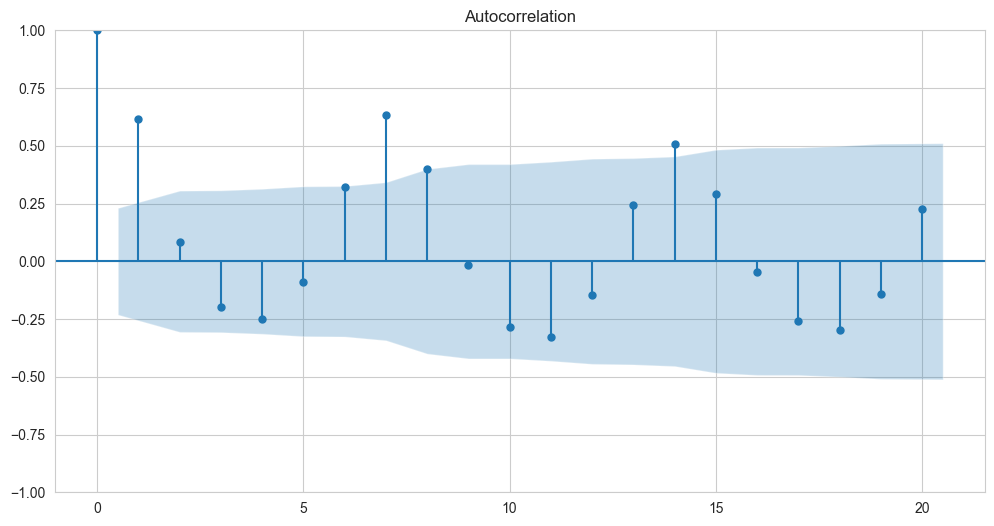

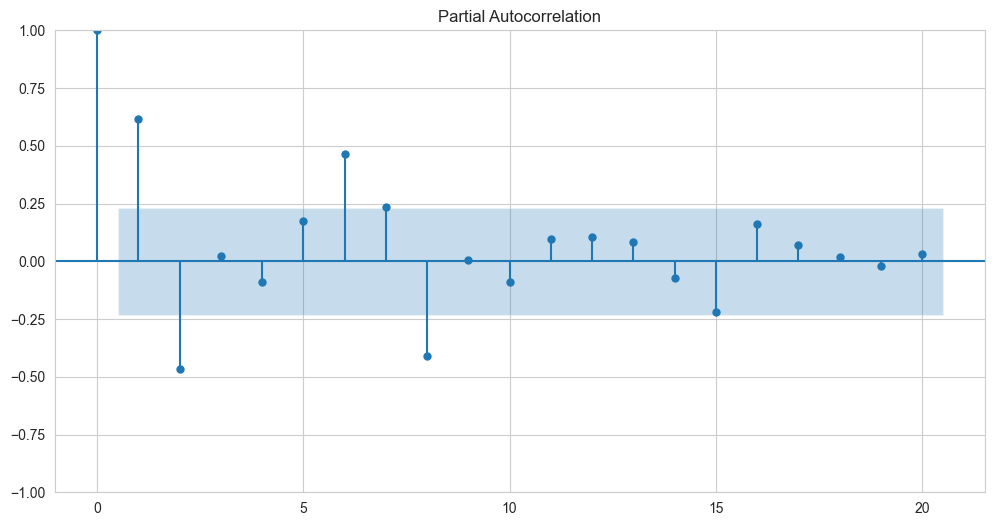

In [15]:
# Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(train_ts, ax=plt.gca(), lags=20)
plt.show()

# Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(train_ts, ax=plt.gca(), lags=20)
plt.show()

### Automatic optimization of parameters with auto_arima

In [16]:
auto_arima_model = auto_arima(train_ts, d=0, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print("Best ARIMA model:", auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2057.936, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2010.250, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1690.038, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1690.044, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1674.696, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2002.019, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1673.945, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2001.211, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1673.736, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1649.397, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1688.149, Time=0.13 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=inf, T

In [17]:
auto_sarima_model = auto_arima(train_ts, d=0, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print("Best SARIMA model:", auto_sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=1464.015, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1487.427, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1464.663, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1466.574, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1491.449, Time=0.00 sec
 ARIMA(2,0,2)(0,1,1)[7] intercept   : AIC=1462.186, Time=0.13 sec
 ARIMA(2,0,2)(0,1,0)[7] intercept   : AIC=1460.222, Time=0.10 sec
 ARIMA(2,0,2)(1,1,0)[7] intercept   : AIC=1462.199, Time=0.14 sec
 ARIMA(1,0,2)(0,1,0)[7] intercept   : AIC=1459.525, Time=0.04 sec
 ARIMA(1,0,2)(1,1,0)[7] intercept   : AIC=1460.819, Time=0.07 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=1460.854, Time=0.08 sec
 ARIMA(1,0,2)(1,1,1)[7] intercept   : AIC=1462.814, Time=0.19 sec
 ARIMA(0,0,2)(0,1,0)[7] intercept   : AIC=1475.365, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=1459.964, Time=0.03 sec
 ARIMA(1,0,3)(0,1,0)[7] intercept

## ARIMA-SARIMA models
### p, d, q parameters

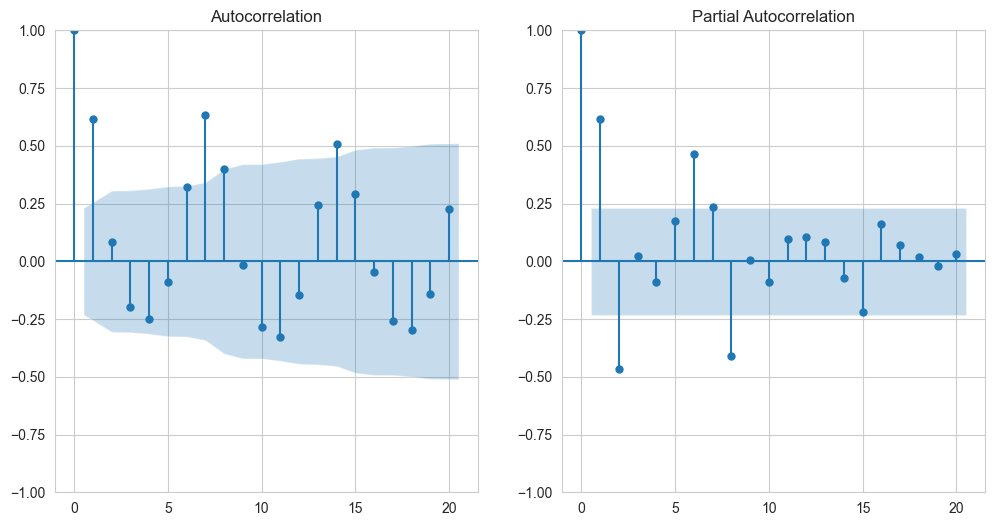

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_ts, ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(train_ts, ax=plt.gca(), lags=20)
plt.show()

In [19]:
model = ARIMA(train_ts, order=(1, 0, 1))

arima_fit = model.fit()

print("\n=== ARIMA Model Summary ===")
print(arima_fit.summary())


=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -828.204
Date:                Mon, 02 Dec 2024   AIC                           1664.408
Time:                        19:44:10   BIC                           1673.514
Sample:                    01-01-2016   HQIC                          1668.033
                         - 03-12-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.825e+05   7924.222     48.264      0.000    3.67e+05    3.98e+05
ar.L1          0.3719      0.159      2.332      0.020       0.059       0.685
ma.L1          0.6023  

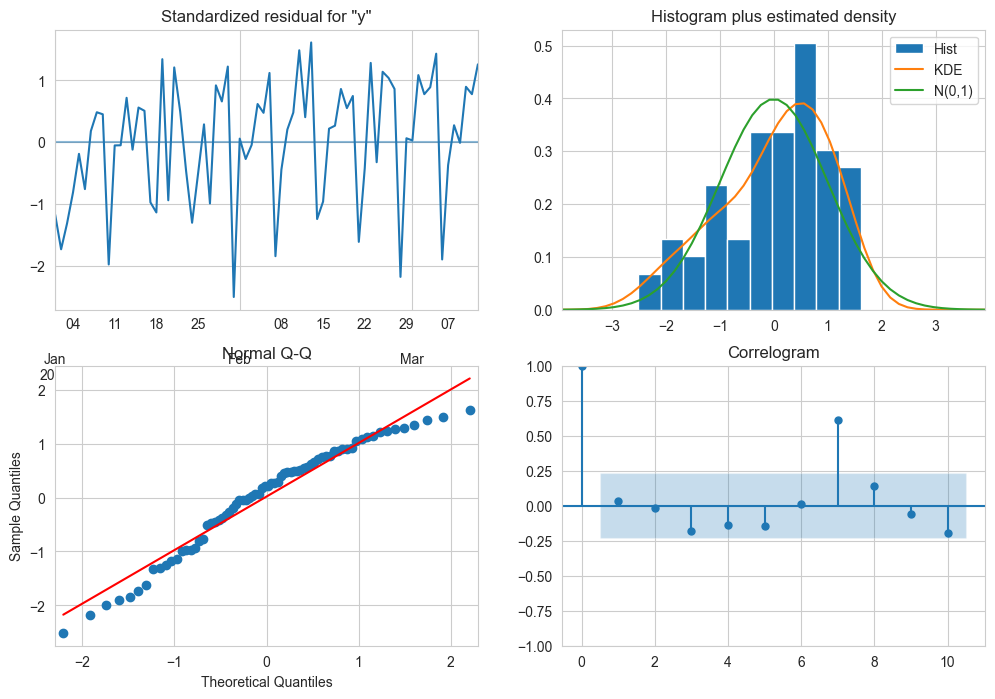

In [20]:
# Diagnostic plots
arima_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [21]:
model_sarima = sm.tsa.statespace.SARIMAX(train_ts, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
sarima_fit = model_sarima.fit(method='bfgs')

print(sarima_fit.summary())

         Current function value: 11.422825
         Iterations: 50
         Function evaluations: 53
         Gradient evaluations: 53


C:\Users\nickb\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\nickb\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\nickb\AppData\Roaming\Python\Python312\site-packages\scipy\optimize\_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -822.443
Date:                           Mon, 02 Dec 2024   AIC                           1654.887
Time:                                   19:44:11   BIC                           1666.270
Sample:                               01-01-2016   HQIC                          1659.418
                                    - 03-12-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9718      0.066     14.660      0.000       0.842       1.102
ma.L1         -0.2068      0.411     -0.503

C:\Users\nickb\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


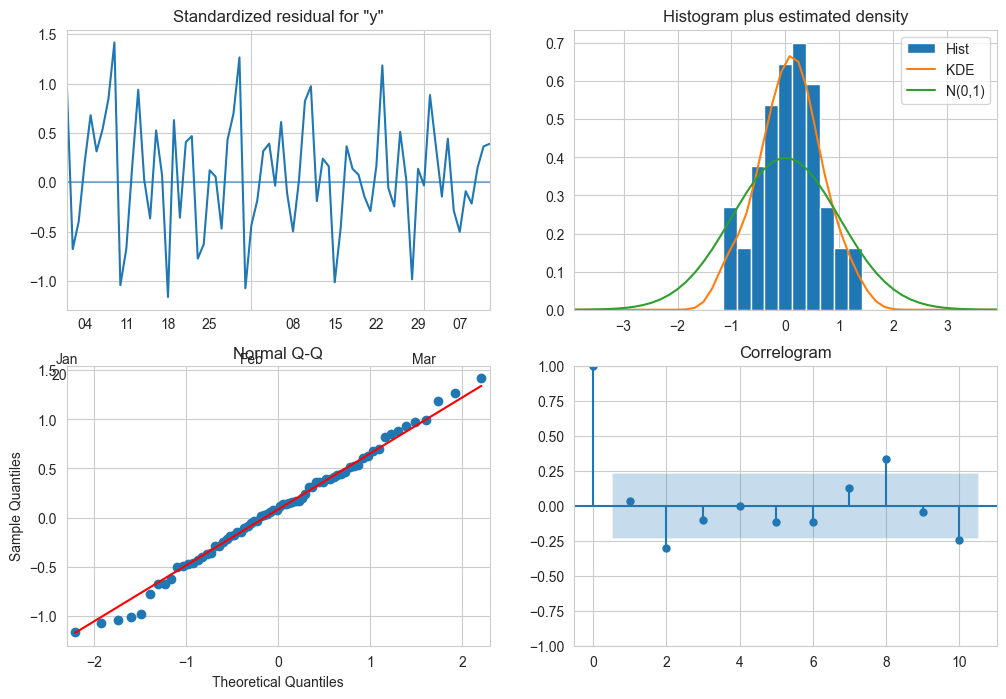

In [22]:
sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

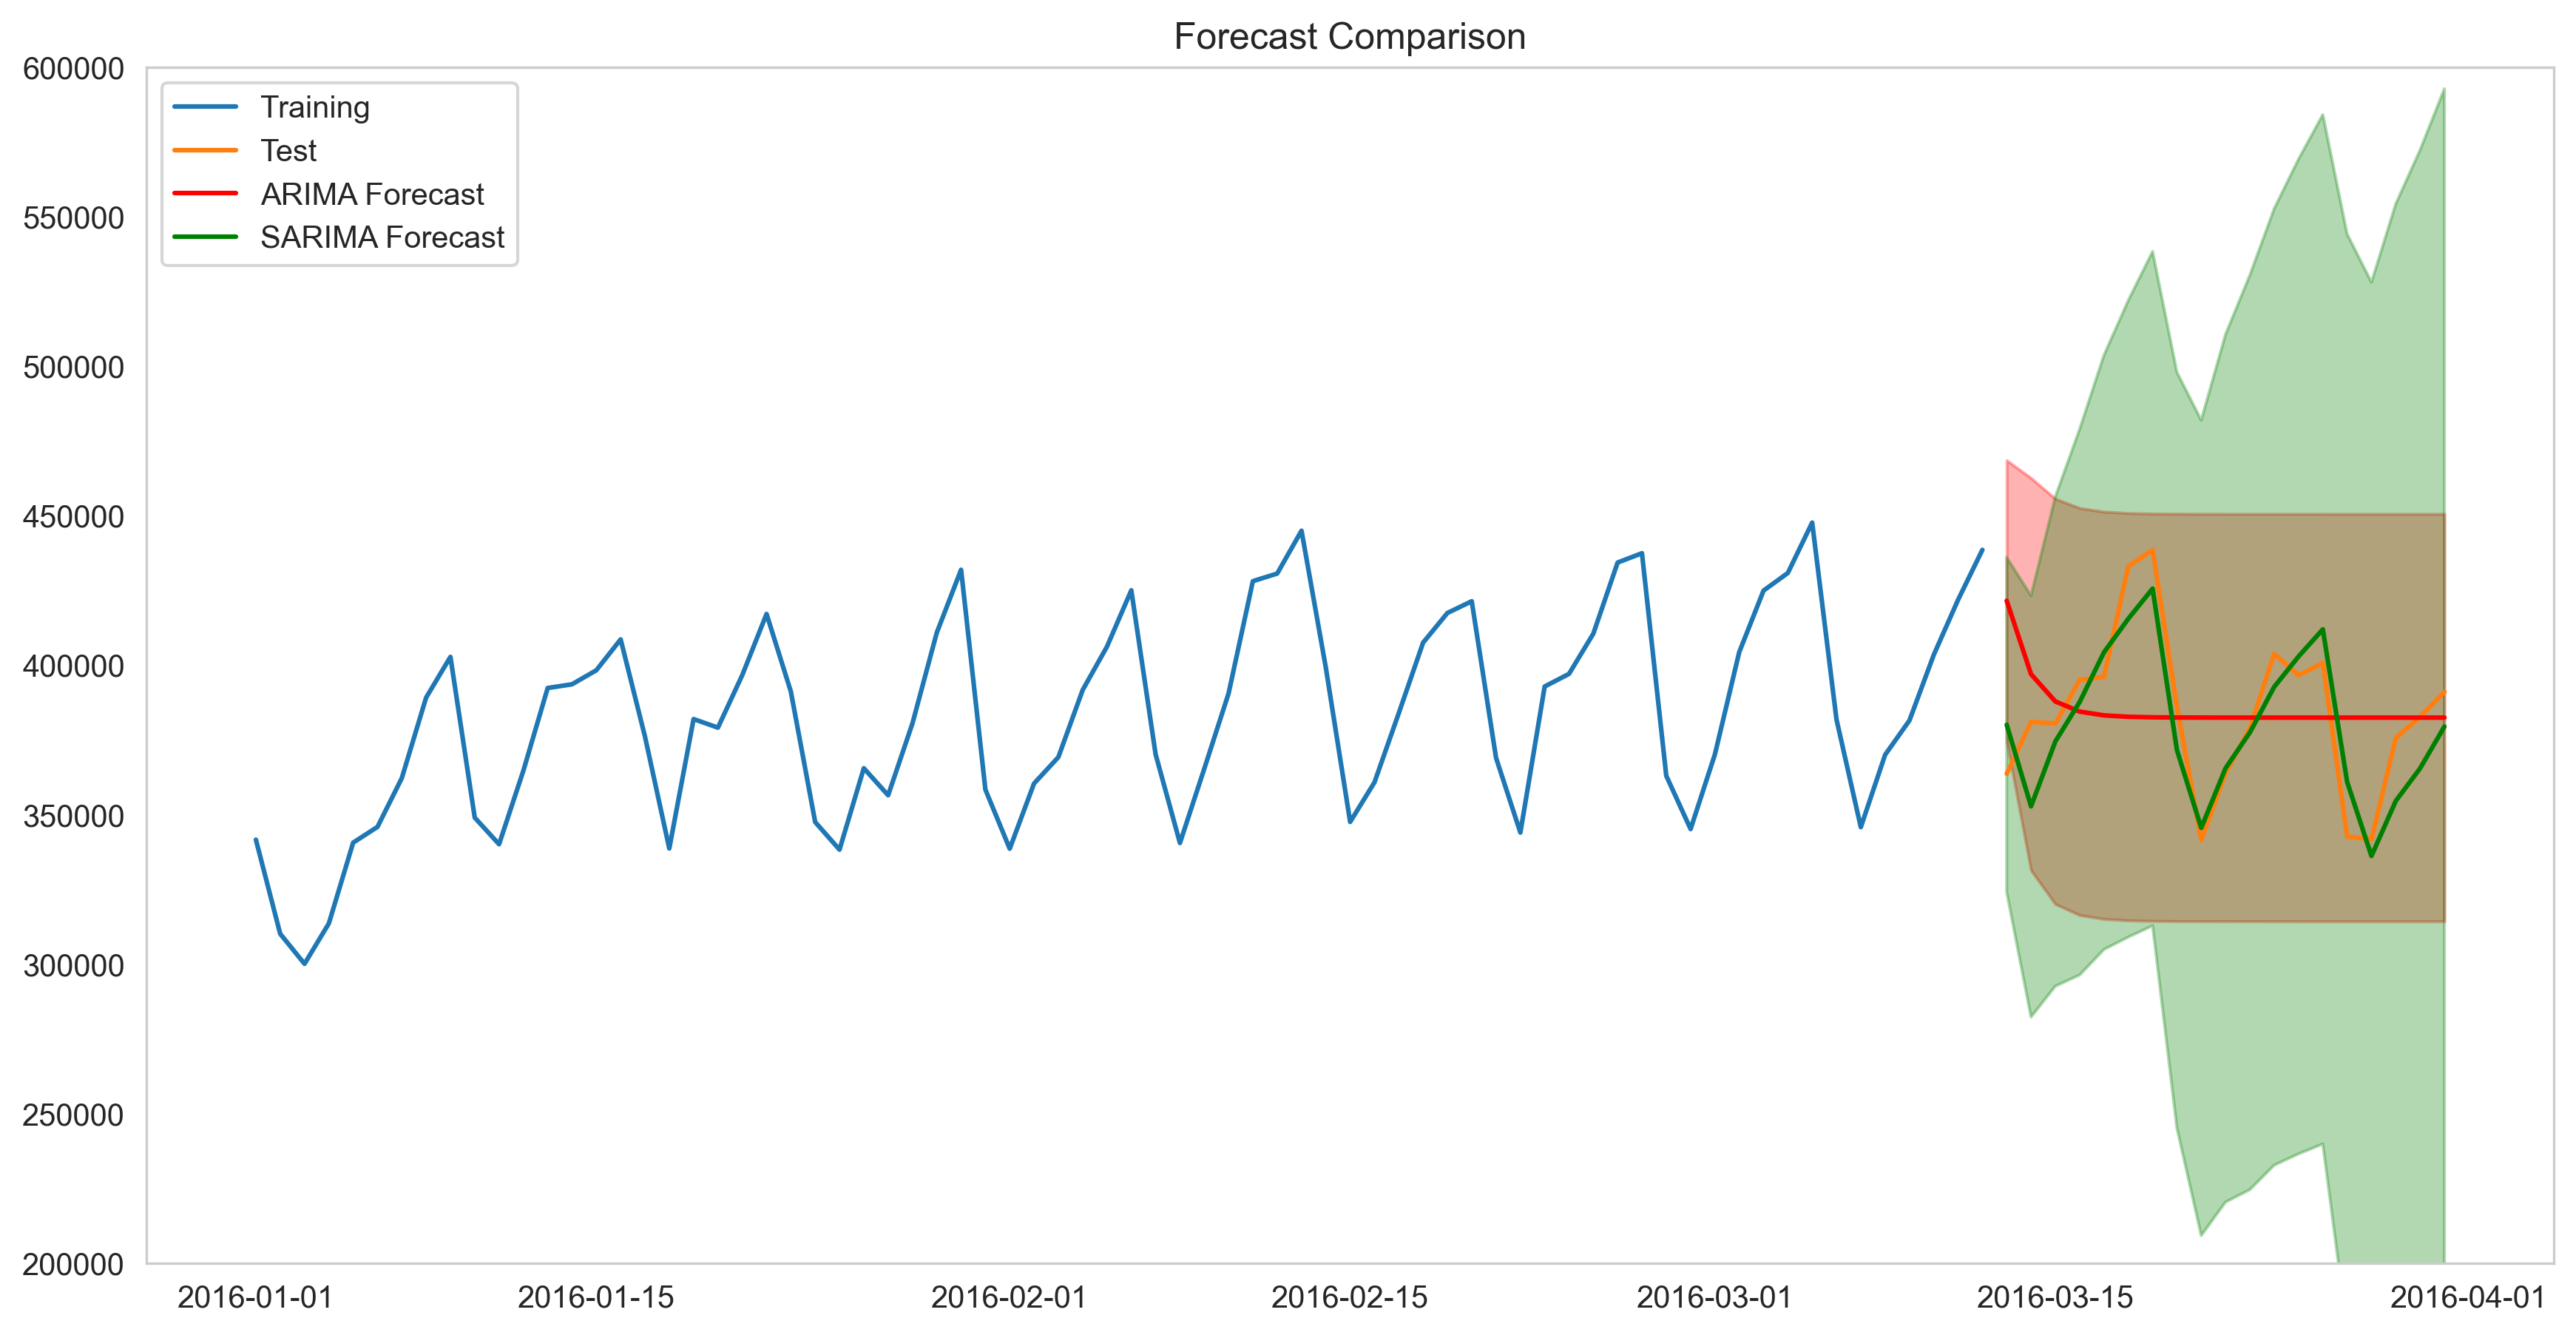

In [23]:
forecast_arima = arima_fit.get_forecast(steps=20)
forecast_sarima = sarima_fit.get_forecast(steps=20)

results = {
    'ARIMA': (forecast_arima.predicted_mean, forecast_arima.se_mean, forecast_arima.conf_int()),
    'SARIMA': (forecast_sarima.predicted_mean, forecast_sarima.se_mean, forecast_sarima.conf_int())
}

arima_fc_series = pd.Series(results['ARIMA'][0], index=test_ts.index)
sarima_fc_series = pd.Series(results['SARIMA'][0], index=test_ts.index)

arima_lower_series = pd.Series(results['ARIMA'][2].iloc[:, 0], index=test_ts.index)
arima_upper_series = pd.Series(results['ARIMA'][2].iloc[:, 1], index=test_ts.index)

sarima_lower_series = pd.Series(results['SARIMA'][2].iloc[:, 0], index=test_ts.index)
sarima_upper_series = pd.Series(results['SARIMA'][2].iloc[:, 1], index=test_ts.index)

plt.figure(figsize=(14, 7), dpi=300)
plt.plot(train_ts, label='Training')
plt.plot(test_ts, label='Test')
plt.plot(arima_fc_series, label='ARIMA Forecast', color='red')
plt.plot(sarima_fc_series, label='SARIMA Forecast', color='green')
plt.ylim(200000, 600000)
plt.fill_between(arima_lower_series.index, arima_lower_series, arima_upper_series, color='red', alpha=0.3)
plt.fill_between(sarima_lower_series.index, sarima_lower_series, sarima_upper_series, color='green', alpha=0.3)
plt.title('Forecast Comparison')
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.show()

# plt.figure(figsize=(14, 7))
# plt.plot(ts_daily_trips, label='Observed')
# plt.plot(forecast_arima.predicted_mean.index, forecast_arima.predicted_mean.values, label='ARIMA Forecast', color='red')
# plt.fill_between(forecast_arima_ci.index, forecast_arima_ci.iloc[:, 0], forecast_arima_ci.iloc[:, 1], color='red', alpha=0.3)
# plt.plot(forecast_sarima.predicted_mean.index, forecast_sarima.predicted_mean.values, label='SARIMA Forecast', color='green')
# plt.fill_between(forecast_sarima_ci.index, forecast_sarima_ci.iloc[:, 0], forecast_sarima_ci.iloc[:, 1], color='green', alpha=0.3)
# plt.title('Forecast Comparison')
# plt.xlabel('Date')
# plt.ylabel('Number of Trips')
# plt.legend()
# plt.grid()
# plt.show()

## Hour based analysis

Escludiamo il file CSV relativo a gennaio 2015 in modo tale da ottenere una sottosezione dell'intero dataset relativa al periodo gennaio2016-febbario2016. In questo modo, in quell'intervallo i dati potranno essere aggragati su base oraria con intervalli uniformi tra ogni osservazione

In [24]:
# Specificare i file rilevanti per gennaio, febbraio e marzo 2016
hour_dfs = [pd.read_csv(f, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) 
            for f in file_paths]
hour_df = pd.concat(hour_dfs, ignore_index=True)

In [25]:
# Rimuovere righe con valori nulli
hour_df.dropna(subset=columns, inplace=True)

# Filtrare viaggi con valori negativi o anomali
hour_df = hour_df[(hour_df['trip_distance'] > 0) & 
                  (hour_df['fare_amount'] > 0) & 
                  (hour_df['total_amount'] > 0)]

# Calcolare la durata del viaggio
hour_df['trip_duration'] = (hour_df['tpep_dropoff_datetime'] - hour_df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filtrare viaggi con durata negativa o eccessiva (>4 ore)
hour_df = hour_df[(hour_df['trip_duration'] > 0) & (hour_df['trip_duration'] < 240)]

In [26]:
# Creare un indice temporale arrotondando al più vicino inizio dell'ora
hour_df['pickup_hour'] = hour_df['tpep_pickup_datetime'].dt.floor('H')

# Aggregare il numero di viaggi per ogni ora
hourly_trips = hour_df.groupby('pickup_hour').size()

# Trasformare in una serie temporale con frequenza fissa
hourly_ts = hourly_trips.asfreq('H', fill_value=0)

# Fill all the hours of January 23-24-25-26, 2016 with the average of the corresponding hours of the corresponding days-of-week in the rest of the dataset
# NOT the average of the corresponding days-of-week, but the average of the corresponding hours
# Riempimento delle ore mancanti basato su medie dello stesso giorno della settimana
for i in range(24):
    hourly_ts[f'2016-01-23 {i:02d}:00:00'] = hourly_ts[
        (hourly_ts.index.hour == i) & (hourly_ts.index.dayofweek == 5)
    ].mean()
    hourly_ts[f'2016-01-24 {i:02d}:00:00'] = hourly_ts[
        (hourly_ts.index.hour == i) & (hourly_ts.index.dayofweek == 6)
    ].mean()


# Train and test
train_size = int(len(hourly_ts) * 0.8)
train_hourly_ts = hourly_ts[:train_size]
test_hourly_ts = hourly_ts[train_size:]

C:\Users\nickb\AppData\Local\Temp\ipykernel_24688\180283675.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour_df['pickup_hour'] = hour_df['tpep_pickup_datetime'].dt.floor('H')
C:\Users\nickb\AppData\Local\Temp\ipykernel_24688\180283675.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_ts = hourly_trips.asfreq('H', fill_value=0)
C:\Users\nickb\AppData\Local\Temp\ipykernel_24688\180283675.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21406.846153846152' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hourly_ts[f'2016-01-23 {i:02d}:00:00'] = hourly_ts[


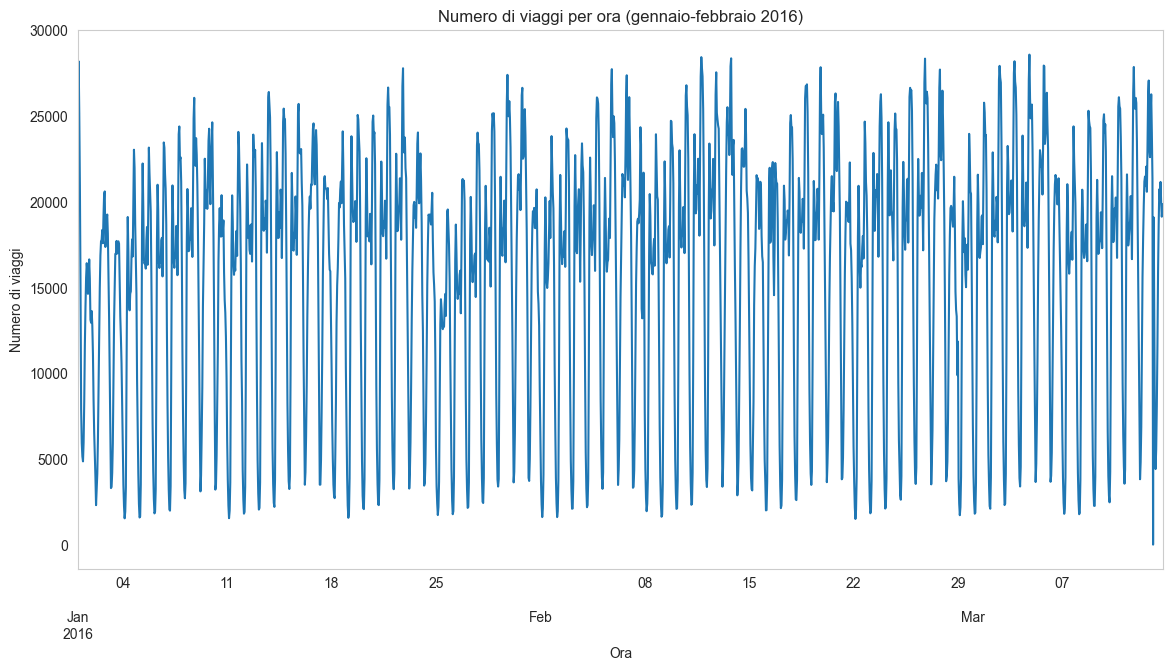

In [27]:
plt.figure(figsize=(14, 7))
train_hourly_ts.plot()
plt.title('Numero di viaggi per ora (gennaio-febbraio 2016)')
plt.xlabel('Ora')
plt.ylabel('Numero di viaggi')
plt.grid()
plt.show()


In [28]:
print("\n[TEST SULLA SERIE ORIGINALE]")
test_stationarity_with_interpretation(train_hourly_ts)


[TEST SULLA SERIE ORIGINALE]
=== Augmented Dickey-Fuller Test ===
ADF Statistic: -4.6006
p-value: 0.00012886333990809486
Critical Values:
   1%: -3.4342
   5%: -2.8632
   10%: -2.5677

✅ La serie è stazionaria


In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

acf_values = acf(train_hourly_ts, nlags=30)
pacf_values = pacf(train_hourly_ts, nlags=30)
print("ACF:", acf_values)
print("PACF:", pacf_values)

ACF: [ 1.          0.90251235  0.69212042  0.4488545   0.20671472 -0.01778762
 -0.20010293 -0.32179146 -0.37425793 -0.36490343 -0.32164677 -0.28129939
 -0.26200123 -0.26249376 -0.28246726 -0.30896609 -0.31449121 -0.27409459
 -0.17980365 -0.03365619  0.14948266  0.34904861  0.55043993  0.72913823
  0.81551314  0.75896372  0.60402915  0.41671548  0.2185526   0.01828904
 -0.16256652]
PACF: [ 1.          0.90302926 -0.6640803   0.078134   -0.20336691 -0.10122839
  0.01153511 -0.01592304  0.04852623 -0.01181137 -0.12570052 -0.19478704
 -0.12858729 -0.10525076 -0.16290195 -0.01139688  0.06443477  0.10517529
  0.10150142  0.14565205  0.11597298  0.18390726  0.32089608  0.29835808
 -0.19033003 -0.29550711  0.18973811  0.18928994 -0.03393237 -0.04943298
 -0.048998  ]


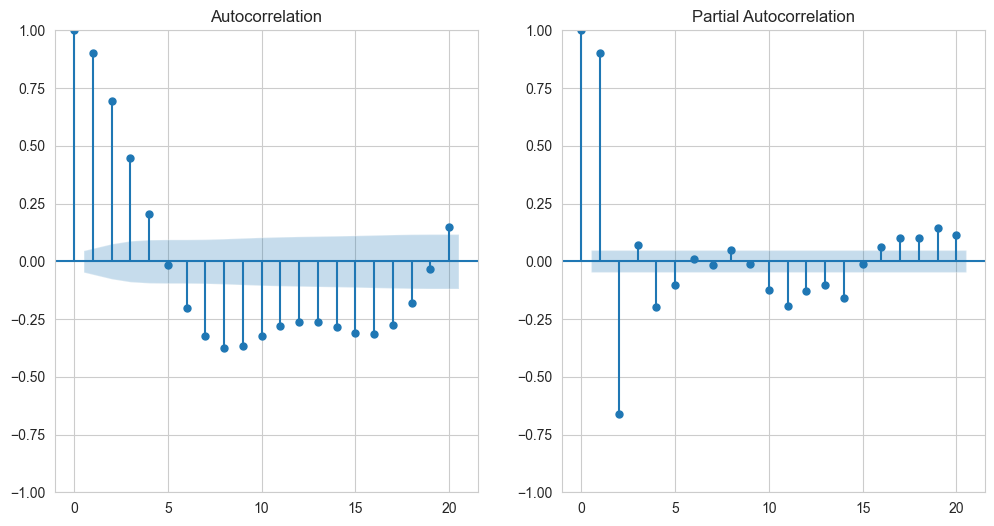

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_hourly_ts, ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(train_hourly_ts, ax=plt.gca(), lags=20)
plt.show()

In [31]:
hourly_arima_model = ARIMA(train_hourly_ts, order=(1, 0, 1))

hourly_arima_fit = hourly_arima_model.fit()

print("\n=== ARIMA Model Summary ===")
print(hourly_arima_fit.summary())


=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1747
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -16135.310
Date:                Mon, 02 Dec 2024   AIC                          32278.621
Time:                        19:45:08   BIC                          32300.484
Sample:                    01-01-2016   HQIC                         32286.703
                         - 03-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.587e+04    662.957     23.940      0.000    1.46e+04    1.72e+04
ar.L1          0.8457      0.016     52.695      0.000       0.814       0.877
ma.L1          0.6122  

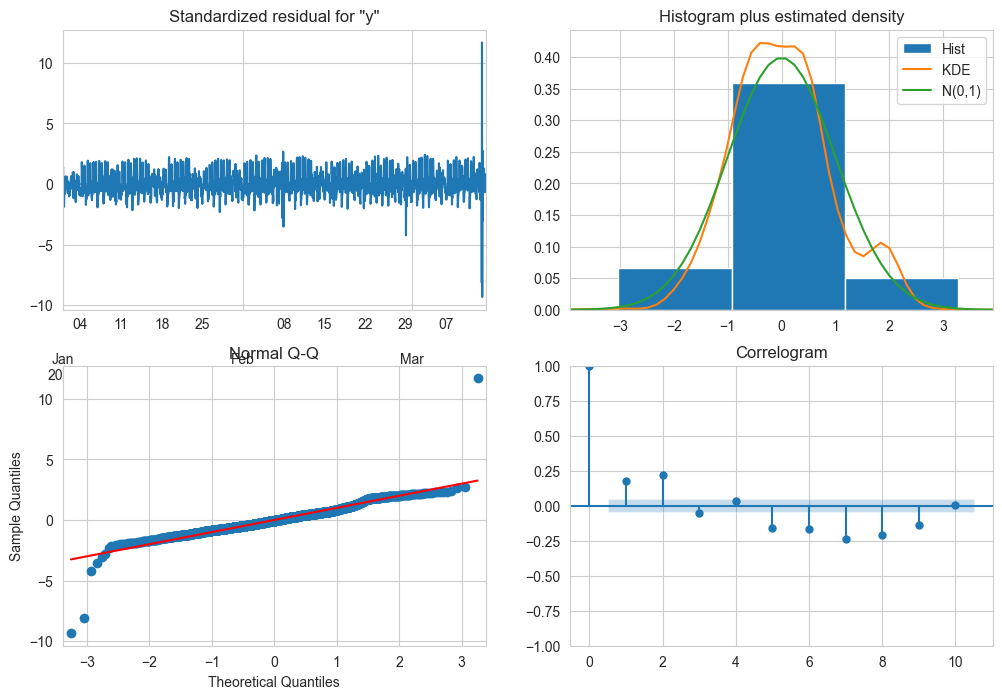

In [32]:
hourly_arima_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [33]:
# Applicare la trasformazione logaritmica
hourly_ts_log = np.log1p(hourly_ts)

# Modello SARIMA
hourly_model_sarima = sm.tsa.statespace.SARIMAX(hourly_ts_log, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
hourly_sarima_fit = hourly_model_sarima.fit()

print(hourly_sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2184
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                -285.741
Date:                            Mon, 02 Dec 2024   AIC                            581.481
Time:                                    19:45:10   BIC                            609.926
Sample:                                01-01-2016   HQIC                           591.879
                                     - 03-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9988      0.001    747.181      0.000       0.996       1.001
ma.L1          0.0548      0.003   

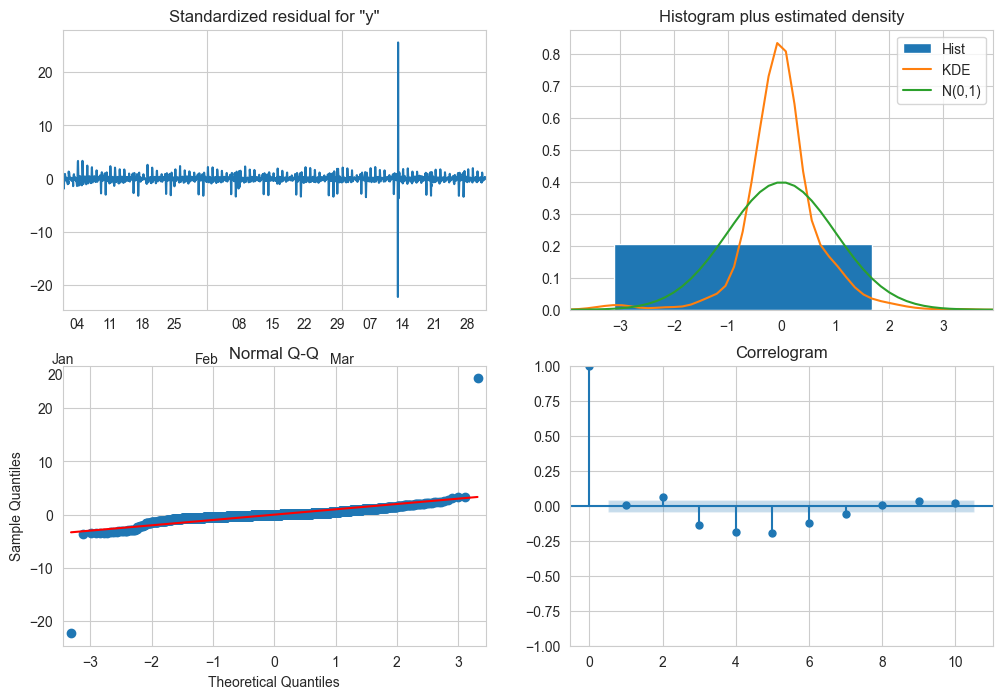

In [34]:
hourly_sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

ARIMA RMSE: 7151.63, MAE: 5924.45
SARIMA RMSE: 10885.23, MAE: 9353.78


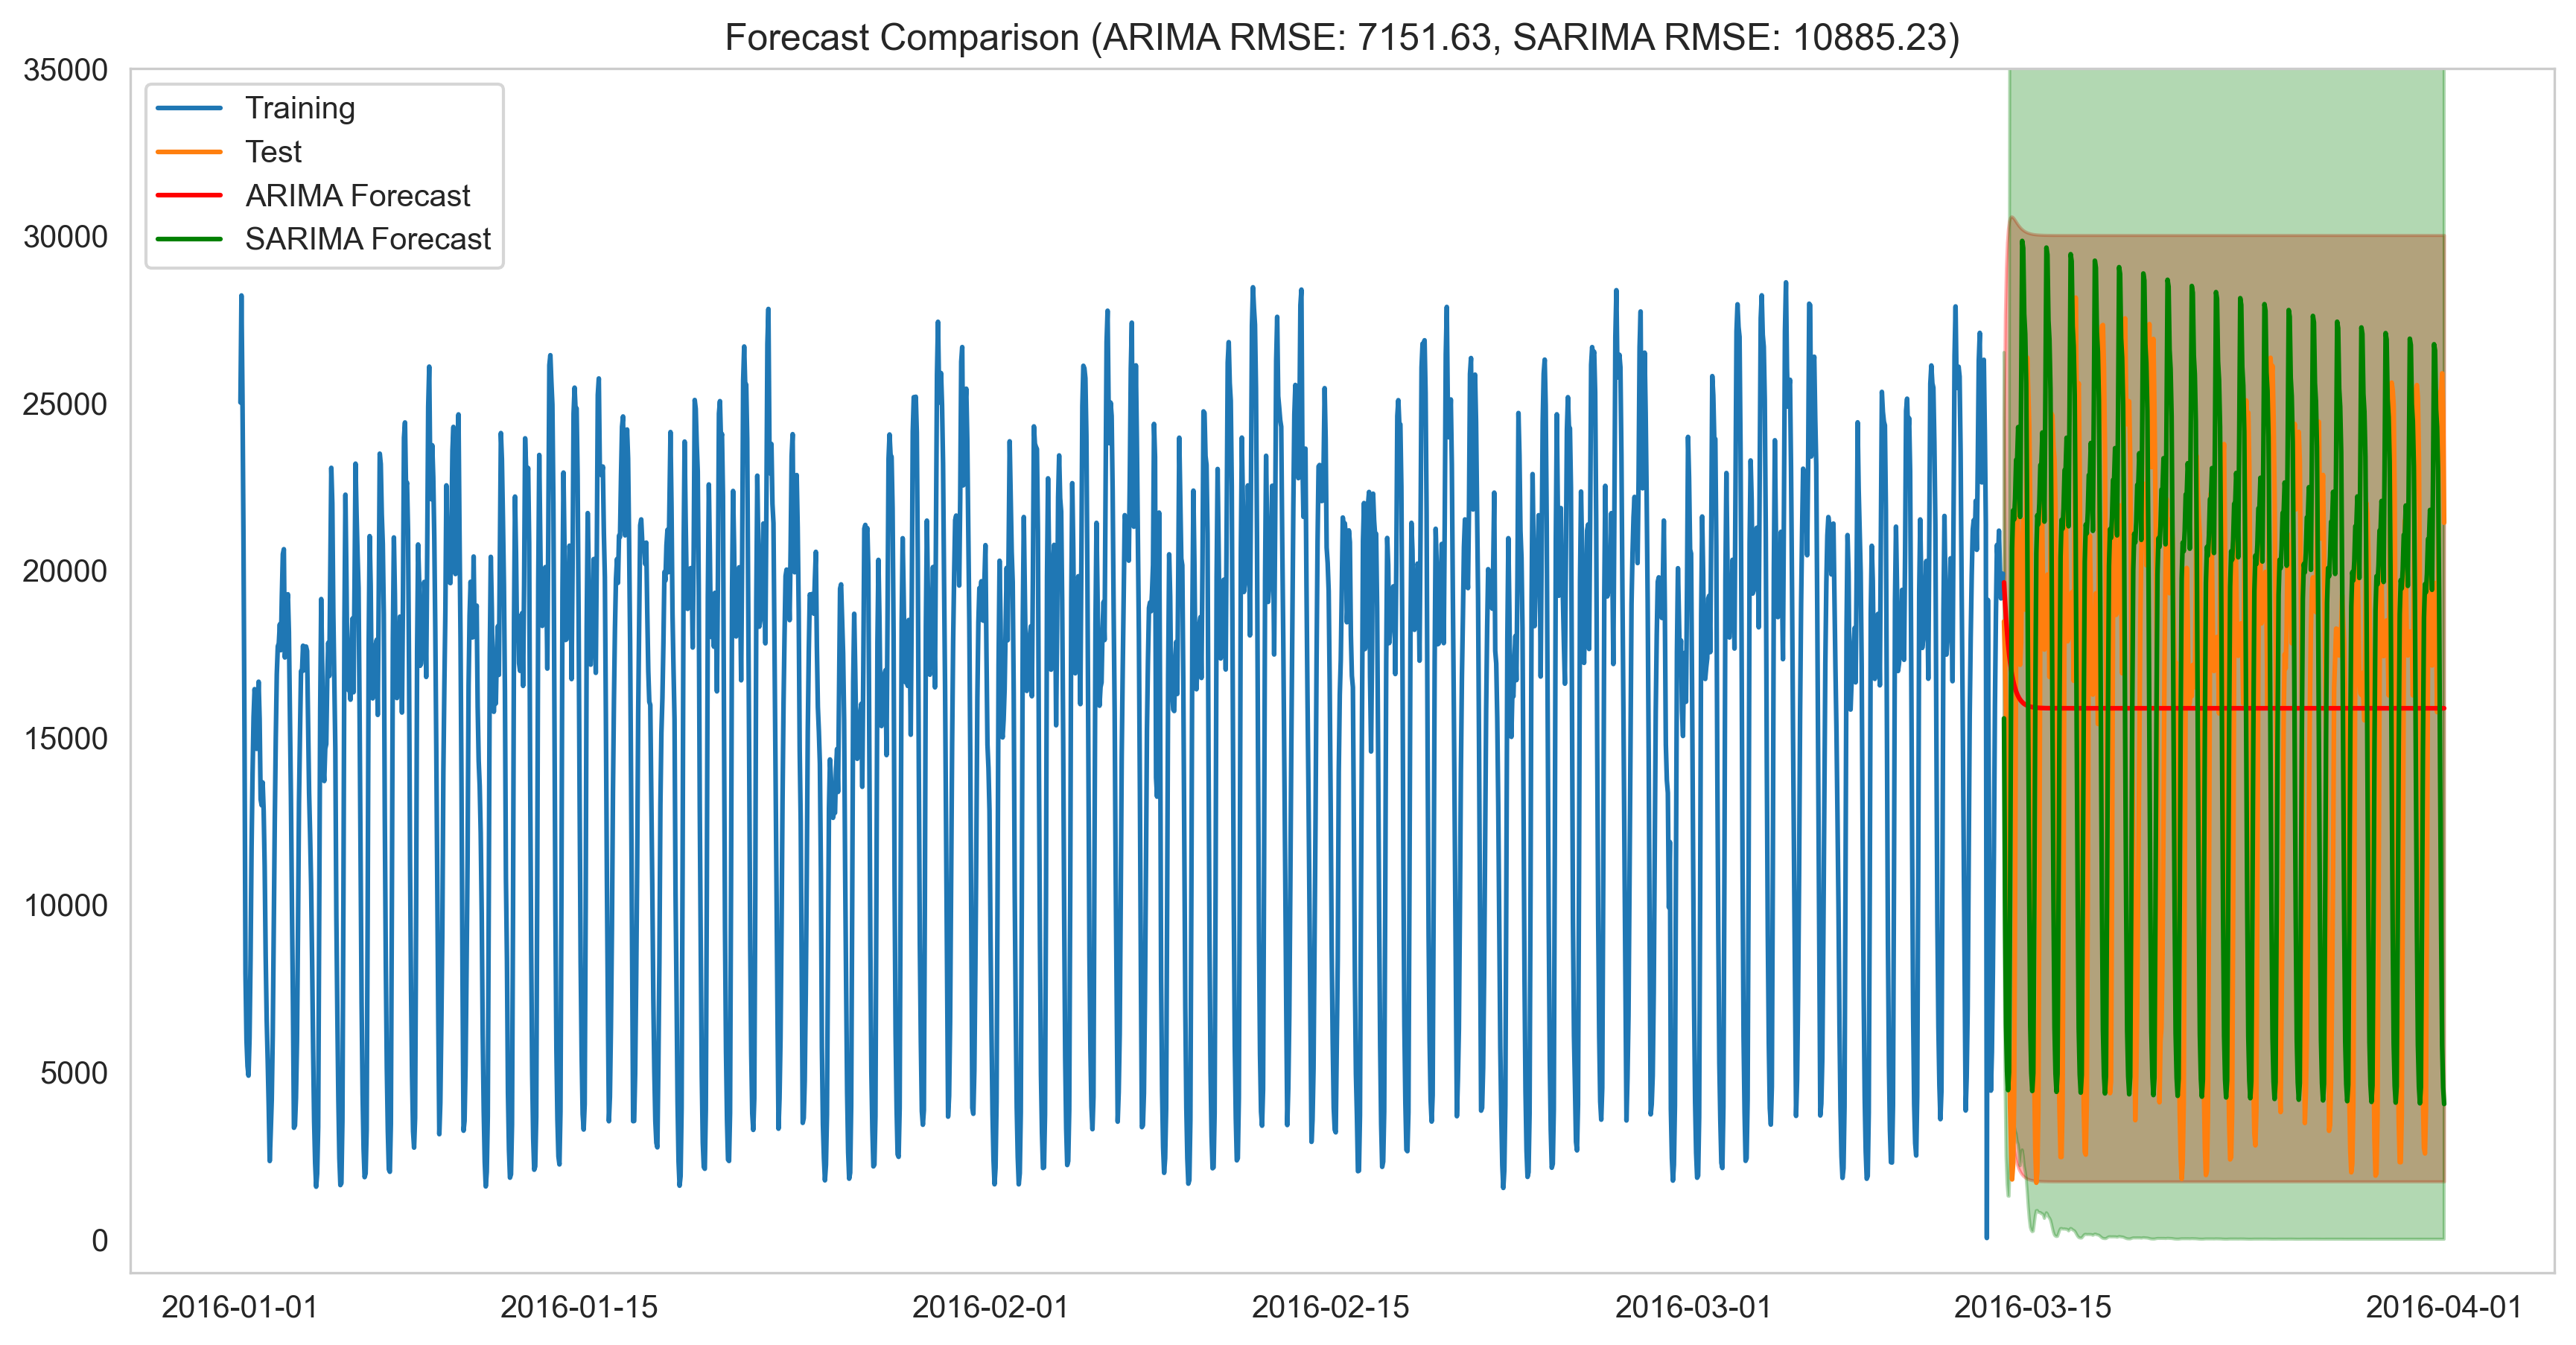

In [35]:
hourly_forecast_arima = hourly_arima_fit.get_forecast(steps=len(test_hourly_ts))
hourly_forecast_sarima_log = hourly_sarima_fit.get_forecast(steps=len(test_hourly_ts))
hourly_forecast_sarima = np.expm1(hourly_forecast_sarima_log.predicted_mean)
hourly_forecast_sarima_se = hourly_forecast_sarima_log.se_mean
hourly_forecast_sarima_ci = np.expm1(hourly_forecast_sarima_log.conf_int())

# Allineare gli indici delle previsioni con il test set
arima_fc_series = pd.Series(hourly_forecast_arima.predicted_mean.values, index=test_hourly_ts.index)
sarima_fc_series = pd.Series(hourly_forecast_sarima.values, index=test_hourly_ts.index)

arima_lower_series = pd.Series(hourly_forecast_arima.conf_int().iloc[:, 0].values, index=test_hourly_ts.index)
arima_upper_series = pd.Series(hourly_forecast_arima.conf_int().iloc[:, 1].values, index=test_hourly_ts.index)

sarima_lower_series = pd.Series(hourly_forecast_sarima_ci.iloc[:, 0].values, index=test_hourly_ts.index)
sarima_upper_series = pd.Series(hourly_forecast_sarima_ci.iloc[:, 1].values, index=test_hourly_ts.index)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcolo delle metriche di errore
arima_rmse = np.sqrt(mean_squared_error(test_hourly_ts, arima_fc_series))
sarima_rmse = np.sqrt(mean_squared_error(test_hourly_ts, sarima_fc_series))
arima_mae = mean_absolute_error(test_hourly_ts, arima_fc_series)
sarima_mae = mean_absolute_error(test_hourly_ts, sarima_fc_series)

print(f"ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
print(f"SARIMA RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")

plt.figure(figsize=(14, 7), dpi=300)
plt.plot(train_hourly_ts, label='Training')
plt.plot(test_hourly_ts, label='Test')
plt.plot(arima_fc_series, label='ARIMA Forecast', color='red')
plt.plot(sarima_fc_series, label='SARIMA Forecast', color='green')
plt.ylim(-1000, 35000)
plt.fill_between(arima_lower_series.index, arima_lower_series, arima_upper_series, color='red', alpha=0.3)
plt.fill_between(sarima_lower_series.index, sarima_lower_series, sarima_upper_series, color='green', alpha=0.3)
plt.title(f'Forecast Comparison (ARIMA RMSE: {arima_rmse:.2f}, SARIMA RMSE: {sarima_rmse:.2f})')
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.show()

C:\Users\nickb\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


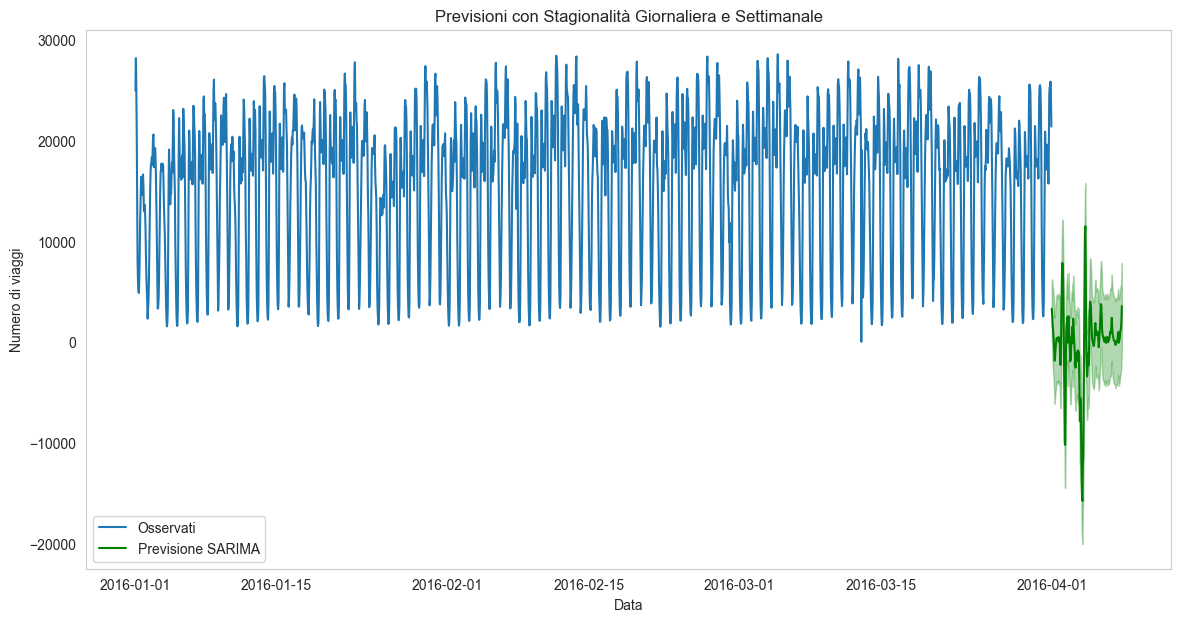

In [36]:
# Differenziazione per la stagionalità giornaliera (24 ore)
hourly_ts_diff = hourly_ts.diff(24).dropna()

# Modello SARIMA considerando la stagionalità settimanale
sarima_model = sm.tsa.statespace.SARIMAX(hourly_ts_diff,
                                         order=(2, 1, 2),  # Parametri ARIMA
                                         seasonal_order=(1, 1, 1, 24 * 7))  # Stagionalità settimanale
sarima_fit = sarima_model.fit()

# Previsioni
forecast = sarima_fit.get_forecast(steps=24 * 7)  # Una settimana di previsioni
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Visualizzazione
plt.figure(figsize=(14, 7))
plt.plot(hourly_ts, label='Osservati')
plt.plot(forecast_mean.index, forecast_mean.values, label='Previsione SARIMA', color='green')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.title('Previsioni con Stagionalità Giornaliera e Settimanale')
plt.xlabel('Data')
plt.ylabel('Numero di viaggi')
plt.legend()
plt.grid()
plt.show()